# Advanced Data Analysis 23/24: group project

By delivering this notebook, we confirm that the code presented was developed by the following students.

## Student 1: GUILHERME RAIMUNDO, 58053
## Student 2: DEWANG BAN, 58200


**In the solutions for exercises 1 to 4 you should include necessarily one solution using Pandas/scikit learn and one using Spark.**

Some useful links:
* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

Run the following cell just to check if it is running in COLAB.

In [ ]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [ ]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.9+9-1~22.04 [48.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.9+9-1~22.04 [71.1 MB]
Fetched 119 MB in 2s (73.1 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 120882 

## Setup

The following cell will import the used packages.

In [ ]:
from zipfile import ZipFile
import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns


## Dataset

In this project, you will be asked to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/sbe2324ada

Mounted at /content/drive
0-68732.csv.gz	      260001-270000.csv.gz  320001-329999.csv.gz  360001-364000.csv.gz
190001-209999.csv.gz  270001-280000.csv.gz  330000-337000.csv.gz  364001-367000.csv.gz
210000-224000.csv.gz  280001-290000.csv.gz  337001-343000.csv.gz  367001-369999.csv.gz
224001-234000.csv.gz  290001-300000.csv.gz  343001-349000.csv.gz  btc_price.csv
234001-247000.csv.gz  300001-310000.csv.gz  349001-354000.csv.gz  labels
247001-260000.csv.gz  310001-320000.csv.gz  354001-360000.csv.gz


In [ ]:
# DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
DATASET_DIR = "/content/drive/MyDrive/sbe2324ada"

# Small dataset
TXDATA_FILE = "0-68732.csv.gz"
# Larger dataset
LGDATA_FILE = "210000-224000.csv.gz"

LGDATA2_FILE = "234001-247000.csv.gz"

# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"



In [ ]:
# DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
LABEL_DIR = "/content/drive/MyDrive/sbe2324ada/labels"

# Labels file
LABELDATA_FILE= "labels-210000-224000.csv.gz"


### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

In [ ]:
# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    date_cols = ["Time"]
    path = os.path.join(DATASET_DIR, filename)
    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz
Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz
Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz
Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz
Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz
Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-

In [ ]:
# Dumps basic infomation using Spark Pandas API
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    df = ps.read_csv( path,compression="gzip")
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-15 11:31:03
Last date : 2014-03-16 01:06:12
FILENAME : 260001-270000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2769663
First block : 260001
Last block : 270000
First date : 2013-09-23 08:31:57
Last date : 2070-04-24 08:28:17
FILENAME : 270001-280000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3661019
First block : 270001
Last block : 280000
First date : 2013-11-14 13:02:11
Last date : 2014-03-16 13:29:27
FILENAME : 280001-290000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2445208
First block : 283895
Last block : 290000
First date : 2014-02-03 04:53:17
Last date : 2014-03-16 13:45:30
FILENAME : 290001-300000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3848932
First block : 290001
Last block : 300000
First date : 2013-03-18 16:57:27
Last date : 2014-05-10 06:32:34
FILENAME : 300001-310000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3771780
First block : 300001
Last block : 310000
First date : 2014-03-09 19:48:36
Last date : 2014-07-09 23:04:51
FILENAME : 310001-320000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4147030
First block : 310001
Last block : 320000
First date : 2014-07-08 20:02:05
Last date : 2014-09-10 13:59:57
FILENAME : 320001-329999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 5006946
First block : 320001
Last block : 329999
First date : 2014-09-06 19:01:22
Last date : 2014-11-14 16:39:17
FILENAME : 330000-337000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4092892
First block : 330000
Last block : 337000
First date : 2014-11-12 23:15:18
Last date : 2015-01-01 19:51:07
FILENAME : 337001-343000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3779208
First block : 337001
Last block : 343000
First date : 2014-12-28 23:00:04
Last date : 2015-02-11 12:21:27
FILENAME : 343001-349000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4014279
First block : 343001
Last block : 349000
First date : 2015-01-30 02:41:44
Last date : 2015-03-24 10:59:08
FILENAME : 349001-354000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3602785
First block : 349001
Last block : 354000
First date : 2015-03-22 20:13:14
Last date : 2015-04-27 23:53:38
FILENAME : 354001-360000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4389567
First block : 354001
Last block : 360000
First date : 2015-04-22 17:49:15
Last date : 2015-06-08 14:08:27
FILENAME : 360001-364000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3278880
First block : 360001
Last block : 364000
First date : 2015-06-04 19:47:52
Last date : 2015-07-05 22:45:33
FILENAME : 364001-367000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2693620
First block : 364001
Last block : 367000
First date : 2015-07-04 17:58:29
Last date : 2015-07-26 02:55:28
FILENAME : 367001-369999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2427472
First block : 367001
Last block : 369999
First date : 2015-07-24 16:32:21
Last date : 2015-08-15 17:51:16


In [ ]:
# Dumps basic infomation using Spark Dataframe load
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    mySchema = StructType([
        StructField("TxId", StringType()),
        StructField("Height", IntegerType()),
        StructField("Input", StringType()),
        StructField("Output", StringType()),
        StructField("Sum", StringType()),
        StructField("Time", TimestampType()),
    ])

    dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
    dataset.createOrReplaceTempView("data")

    statistics = spark.sql( """SELECT COUNT( *) AS num_transactions,
                                  MIN( Height) AS first_block,
                                  MAX( Height) AS last_block,
                                  MIN( Time) AS first_time,
                                  MAX( Time) AS last_time
                                  FROM data""")
    statistics.show()


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
+----------------+-----------+----------+-------------------+-------------------+
|num_transactions|first_block|last_block|         first_time|          last_time|
+----------------+-----------+----------+-------------------+-------------------+
|           14832|        546|     68732|2009-01-15 06:08:20|2010-07-17 16:54:44|
+----------------+-----------+----------+-------------------+-------------------+

FILENAME : 190001-209999.csv.gz
+----------------+-----------+----------+-------------------+-------------------+
|num_transactions|first_block|last_block|         first_time|          last_time|
+----------------+-----------+----------+-------------------+-------------------+
|         4183123|     190001|    209999|2012-07-19 09:43:01|2014-03-12 22:49:29|
+----------------+-----------+----------+-------------------+-------------------+

FILENAME : 210000-224000.csv.gz
+----------------+-----------+----------+-----------------

### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [ ]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)

TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value             object
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


We repeat the same computation in Spark SQL, creating views with the same names.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()


root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [ ]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv( path,parse_dates=date_cols)
print(priceDF)
priceDF.dtypes


           Date    Price
0    2009-01-15      0.1
1    2009-01-16      0.1
2    2009-01-17      0.1
3    2009-01-18      0.1
4    2009-01-19      0.1
...         ...      ...
5417 2023-11-15  37874.9
5418 2023-11-16  36161.2
5419 2023-11-17  36595.4
5420 2023-11-18  36568.6
5421 2023-11-19  36792.1

[5422 rows x 2 columns]


Date     datetime64[ns]
Price           float64
dtype: object

### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


## Exercise 0 [1 point]

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### Pandas code

In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


                                    cnt_in  cnt_out     cnt
18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT    10.0   3658.0  3668.0
1XPTgDRhN8RFnzniWCddobD9iKZatrvH4     12.0   3125.0  3137.0
1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp     6.0    594.0   600.0
15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC     6.0    306.0   312.0
1JC495jBZFoYnoHEbej8gCgZTBxQpAM6ma     1.0    207.0   208.0
15VjRaDX9zpbA8LVnbrCAFzrVzN7ixHNsC    93.0    109.0   202.0
1FeFgJRvCYUTCBj1u696eL23xpAdNB4B8p     1.0    146.0   147.0
1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV    10.0    137.0   147.0
16RCdSYjvj6PpCcbAWVzoArQaYVz3Tf5W4    43.0     83.0   126.0
18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk    16.0    106.0   122.0
Runtime = 0.585313081741333


In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, LGDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


                                      cnt_in   cnt_out       cnt
1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp   360501.0  359025.0  719526.0
1dice97ECuByXAvqXpaYzSaQuPVvrtmz6   273140.0  272816.0  545956.0
1dice7W2AicHosf5EL3GFDUVga7TgtPFn   126485.0  126751.0  253236.0
1dice9wcMu5hLF4g81u8nioL5mmSHTApw   121250.0  121327.0  242577.0
1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx    93528.0   93880.0  187408.0
1VayNert3x1KzbpzMGt2qdqrAThiRovi8    73204.0   73972.0  147176.0
1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc    70278.0   70243.0  140521.0
1sLiMbvDGgJjKKzUYsJ2QB9MXiHeeRnCD    62974.0   65559.0  128533.0
1dice6YgEVBf88erBFra9BHf6ZMoyvG88    60662.0   60991.0  121653.0
1Bd5wrFxHYRkk4UCFttcPNMYzqJnQKfXUE   58410.0   61804.0  120214.0
Runtime = 269.5265197753906


### Results (Pandas)

The time to process the small dataset was : **0.59** seconds.

The time to process the large dataset was : **270** seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+------------------------------------+----+------+-------+
|addr                                |cnt |cnt_in|cnt_out|
+------------------------------------+----+------+-------+
|'18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT'|3668|10    |3658   |
|'1XPTgDRhN8RFnzniWCddobD9iKZatrvH4' |3137|12    |3125   |
|'1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp'|600 |6     |594    |
|'15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC'|312 |6     |306    |
|'1JC495jBZFoYnoHEbej8gCgZTBxQpAM6ma'|208 |1     |207    |
|'15VjRaDX9zpbA8LVnbrCAFzrVzN7ixHNsC'|202 |93    |109    |
|'1FeFgJRvCYUTCBj1u696eL23xpAdNB4B8p'|147 |1     |146    |
|'1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV'|147 |10    |137    |
|'16RCdSYjvj6PpCcbAWVzoArQaYVz3Tf5W4'|126 |43    |83     |
|'18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk'|122 |16    |106    |
+------------------------------------+----+------+-------+

Runtime = 1.1753313541412354


In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, LGDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

+------------------------------------+------+------+-------+
|addr                                |cnt   |cnt_in|cnt_out|
+------------------------------------+------+------+-------+
|'1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp' |719526|360501|359025 |
|'1dice97ECuByXAvqXpaYzSaQuPVvrtmz6' |545956|273140|272816 |
|'1dice7W2AicHosf5EL3GFDUVga7TgtPFn' |253236|126485|126751 |
|'1dice9wcMu5hLF4g81u8nioL5mmSHTApw' |242577|121250|121327 |
|'1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx' |187408|93528 |93880  |
|'1VayNert3x1KzbpzMGt2qdqrAThiRovi8' |147176|73204 |73972  |
|'1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc' |140521|70278 |70243  |
|'1sLiMbvDGgJjKKzUYsJ2QB9MXiHeeRnCD' |128533|62974 |65559  |
|'1dice6YgEVBf88erBFra9BHf6ZMoyvG88' |121653|60662 |60991  |
|'1Bd5wrFxHYRkk4UCFttcPNMYzqJnQKfXUE'|120214|58410 |61804  |
+------------------------------------+------+------+-------+

Runtime = 122.24193906784058


### Results (Spark)

The time to process the small dataset was : **1.18** seconds.

The time to process the large dataset was : **122** seconds.



### Discussion:

**Spark SQL is faster than Pandas for larger datasets but slower for smaller ones. For small datasets, Spark's initialization and data distribution across nodes introduces significant overhead. But since Spark is designed for distributed computing which processes data in parallel across multiple nodes, so it significantly speeds up operations on larger datasets.**

## Exercise 1 [3 points]

This first group consists in computing some statistics on the infomration available in the dataset.

The smallest dataset might lead to strange results for some statistics. Use it while you are developing you project, but if you run into strange results, just use a larger one.




### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")

transactionSDF.createOrReplaceTempView("transaction")

top10_transactions = spark.sql("""
    SELECT *
    FROM transaction
    ORDER BY sum DESC
    LIMIT 10
""").show()


+---------+------+---------+-------------------+
|     txid|height|      sum|               time|
+---------+------+---------+-------------------+
|219029:17|219029|53880.043|2013-02-01 04:36:52|
| 219026:0|219026|50180.043|2013-02-01 04:18:03|
| 219027:7|219027|50180.043|2013-02-01 04:36:05|
| 218541:0|218541|50001.312|2013-01-29 06:44:05|
| 223092:0|223092|44864.207|2013-02-25 18:07:28|
| 218515:0|218515|40001.133|2013-01-29 02:20:22|
| 212094:0|212094|  35000.0|2012-12-13 19:05:45|
| 210986:0|210986|  33000.0|2012-12-05 13:05:46|
| 210995:3|210995| 32628.37|2012-12-05 15:37:29|
| 211132:0|211132| 32528.37|2012-12-06 15:22:36|
+---------+------+---------+-------------------+



### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
# Convert DataFrame priceDF to Spark DataFrame priceDFS
priceDFS = spark.createDataFrame(priceDF)

# Create a TempView
priceDFS.createOrReplaceTempView("price")

# Our logic is to merge the two TempView transaction and price, then use sum * price to get real value in USD
top10_transactions_USD = spark.sql("""
    SELECT t.txid, t.height, t.sum, t.time, p.Price, (t.sum * p.Price) as value_usd
    FROM transaction t
    JOIN price p ON date_trunc('day', t.time) = p.Date
    ORDER BY value_usd DESC
    LIMIT 10
""").show()

+----------+------+---------+-------------------+-----+-----------------+
|      txid|height|      sum|               time|Price|        value_usd|
+----------+------+---------+-------------------+-----+-----------------+
|  223092:0|223092|44864.207|2013-02-25 18:07:28| 30.4|    1363871.89375|
| 219029:17|219029|53880.043|2013-02-01 04:36:52| 20.5|1104540.880859375|
|  219026:0|219026|50180.043|2013-02-01 04:18:03| 20.5|1028690.880859375|
|  219027:7|219027|50180.043|2013-02-01 04:36:05| 20.5|1028690.880859375|
|  218541:0|218541|50001.312|2013-01-29 06:44:05| 19.5|     975025.59375|
|  218515:0|218515|40001.133|2013-01-29 02:20:22| 19.5|  780022.08984375|
|  222086:3|222086| 25000.01|2013-02-20 01:23:50| 29.6|   740000.2890625|
|222086:296|222086|24999.998|2013-02-20 01:25:33| 29.6|739999.9421875001|
|  221938:0|221938|24996.918|2013-02-19 02:36:27| 29.4|734909.3882812499|
|  223569:0|223569|  22000.0|2013-02-28 11:14:45| 33.4|         734800.0|
+----------+------+---------+---------

### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


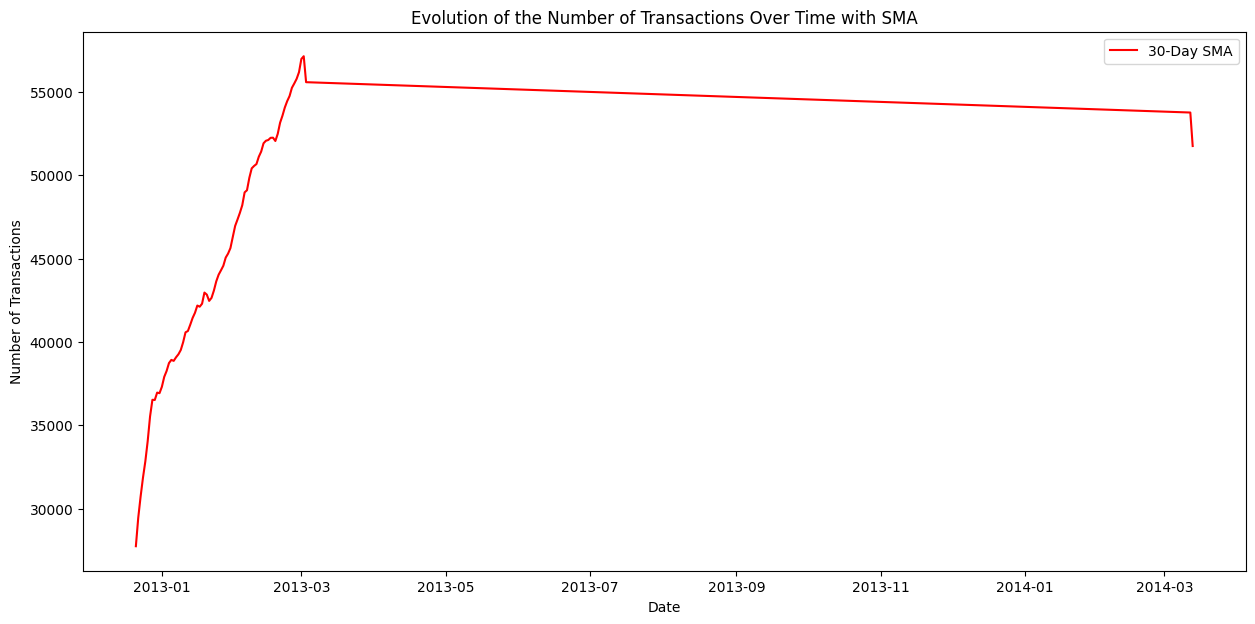

In [ ]:
import matplotlib.pyplot as plt

transaction_counts_day = spark.sql("""
    SELECT to_date(time) as Date, COUNT(*) as number_of_transactions
    FROM transaction
    GROUP BY to_date(time)
    ORDER BY Date
""")

# Convert the result to a Pandas DataFrame
transaction_counts_day_pd = transaction_counts_day.toPandas()


rolling_window_size = 30

# Calculate the SMA in a monthly basis
transaction_counts_day_pd['SMA'] = transaction_counts_day_pd['number_of_transactions'].rolling(window=rolling_window_size).mean()

# Plot
plt.figure(figsize=(15, 7))
plt.plot(transaction_counts_day_pd['Date'], transaction_counts_day_pd['SMA'], label=f'{rolling_window_size}-Day SMA', color='red')
plt.title('Evolution of the Number of Transactions Over Time with SMA')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()

**We used the Simple Moving Average to show the number of transactions over time in a monthly basis, making the line more smooth.**

The previous one without SMA is shown below.

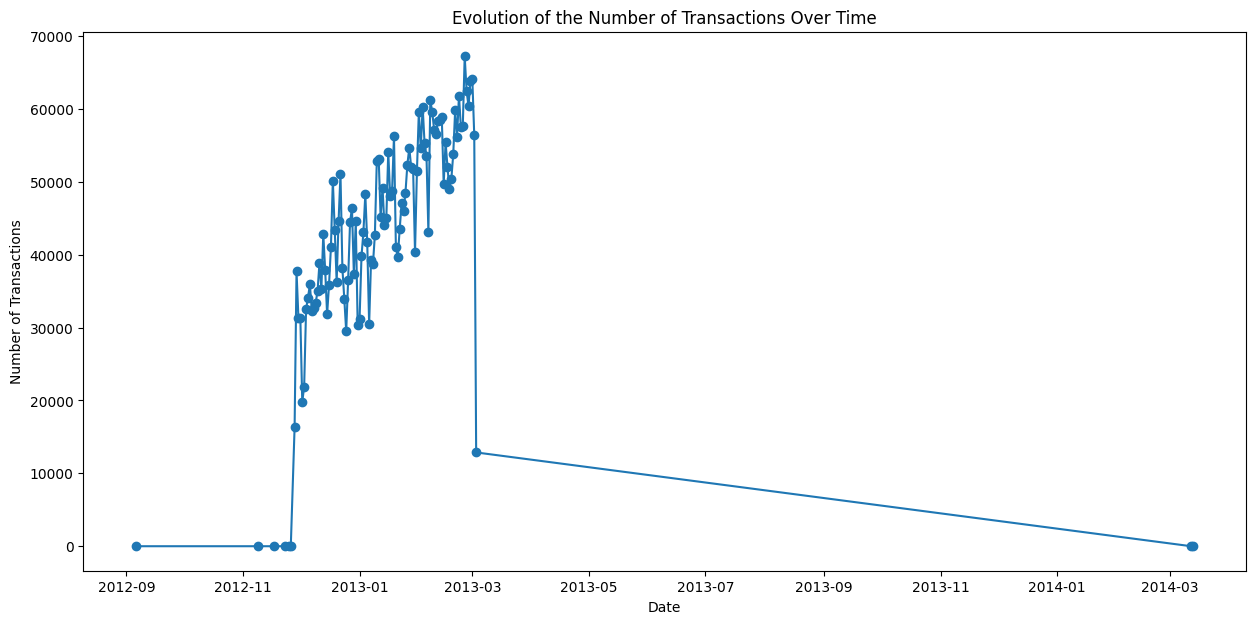

In [ ]:
# Plot
plt.figure(figsize=(15, 7))
plt.plot(transaction_counts_day_pd['Date'], transaction_counts_day_pd['number_of_transactions'], marker='o')
plt.title('Evolution of the Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


+-------------------+--------------------+
|               Date|    total_amount_btc|
+-------------------+--------------------+
|2012-09-01 00:00:00|0.014000030234456062|
|2012-11-01 00:00:00|  2663836.0331651196|
|2012-12-01 00:00:00| 5.025106454585444E7|
|2013-01-01 00:00:00|  5.15911742939997E7|
|2013-02-01 00:00:00|4.2510050778081186E7|
|2013-03-01 00:00:00|  3415451.5922718677|
|2014-03-01 00:00:00|   331.5148032065481|
+-------------------+--------------------+

+-------------------+--------------------+-----+--------------------+
|               Date|    total_amount_btc|Price|    total_amount_usd|
+-------------------+--------------------+-----+--------------------+
|2012-09-01 00:00:00|0.014000030234456062| 10.0| 0.14000030234456062|
|2012-11-01 00:00:00|  2663836.0331651196| 10.6|2.8236661951550268E7|
|2012-12-01 00:00:00| 5.025106454585444E7| 12.6|  6.33163413277766E8|
|2013-01-01 00:00:00|  5.15911742939997E7| 13.3| 6.861626181101961E8|
|2013-02-01 00:00:00|4.2510050778081

<Figure size 1500x700 with 0 Axes>

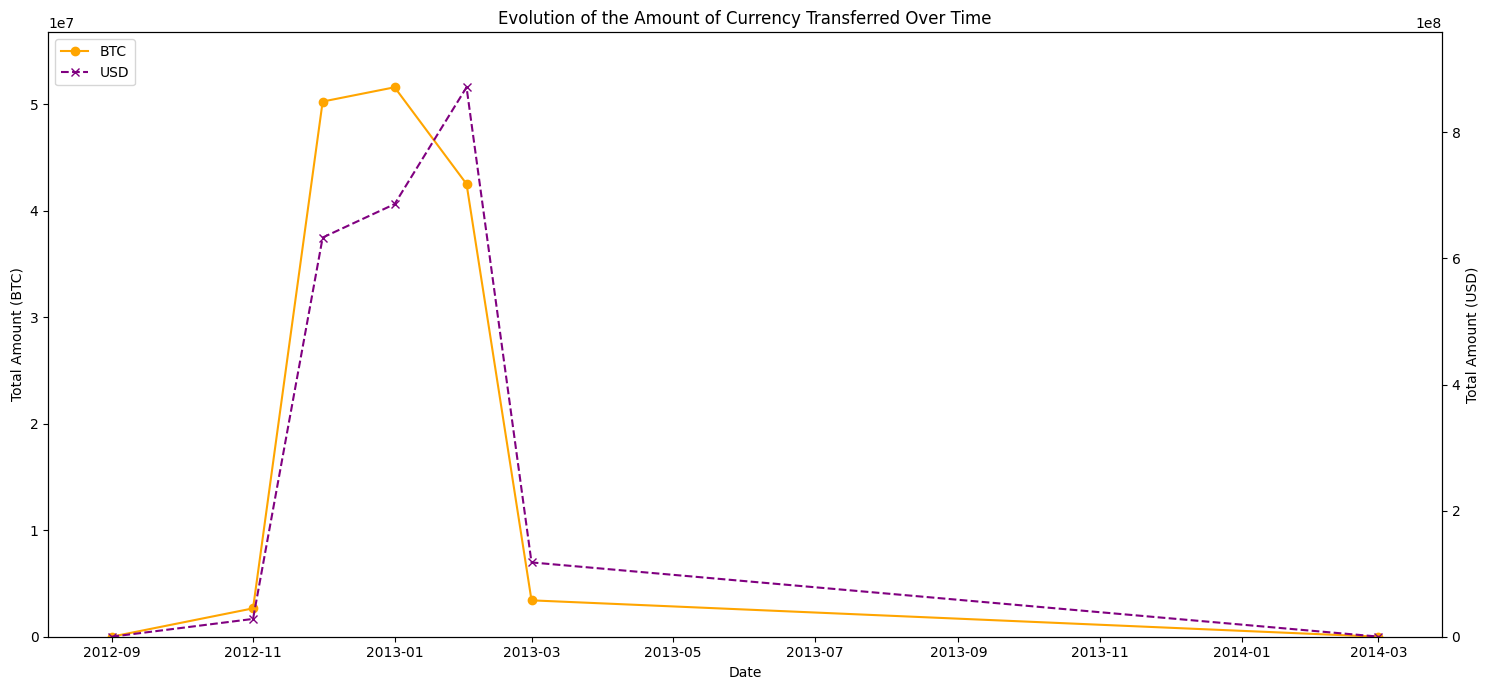

In [ ]:
# Calculate the total amount per day in BTC over time
total_amount_day_btc= spark.sql("""SELECT date_trunc('month', time) as Date, SUM(sum) as total_amount_btc
    FROM transaction
    GROUP BY Date
    ORDER BY Date
    """)

total_amount_day_btc.show()

# Create a TempView
total_amount_day_btc.createOrReplaceTempView("total_amount_day_btc")


# Calculate the total amount per day in USD over time=
total_amount_day_usd= spark.sql(""" SELECT tadb.Date, tadb.total_amount_btc, p.Price, tadb.total_amount_btc * p.Price as total_amount_usd
FROM total_amount_day_btc tadb
JOIN price p ON tadb.Date = p.Date
ORDER BY tadb.Date
""")
total_amount_day_usd.show()

# Back to Pandas
amount_day = total_amount_day_usd.toPandas()
print(amount_day.head())

plt.figure(figsize=(15, 7))

max_btc = amount_day['total_amount_btc'].max()
max_usd = amount_day['total_amount_usd'].max()

plt.figure(figsize=(15, 7))


# Plot BTC values on the primary y-axis
ax1 = plt.gca()
btc_plot, = ax1.plot(amount_day['Date'], amount_day['total_amount_btc'], label='BTC', color='orange', marker='o')
ax1.set_ylabel('Total Amount (BTC)')
ax1.set_ylim(0, max_btc * 1.1)  # Adjust the primary y-axis limit

# Create secondary y-axis for USD values
ax2 = ax1.twinx()
usd_plot, = ax2.plot(amount_day['Date'], amount_day['total_amount_usd'], label='USD', color='purple', marker='x', linestyle='--')
ax2.set_ylabel('Total Amount (USD)')
ax2.set_ylim(0, max_usd * 1.1)  # Adjust the secondary y-axis limit

# Titles and labels
plt.title('Evolution of the Amount of Currency Transferred Over Time')
ax1.set_xlabel('Date')

# Combine legends from both axes
plots = [btc_plot, usd_plot]
labels = [plot.get_label() for plot in plots]
plt.legend(plots, labels, loc='upper left')

plt.tight_layout()
plt.show()


## Exercise 2 [4 points]

Assume you want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

Write the code to build these indices - for each index, print 5 lines.

**NOTE:** use the data from a single dataset file (even knowing that the value of the account balance would need to include processing all transactions).


In [ ]:
import os
import ast
import pandas as pd
import random

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv(path, compression="gzip", parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId", "Height", "Input", "Sum", "Time"]].explode("Input")
outputDF = df[["TxId", "Height", "Output", "Sum", "Time"]].explode("Output")
outputDF[["Output", "Value"]] = outputDF["Output"].to_list()
transactionDF = df[["TxId", "Height", "Sum", "Time"]]

transactions_df = pd.merge(transactionDF, inputDF, left_on="TxId", right_on="TxId", suffixes=('_transaction', '_input'))
transactions_df = pd.merge(transactions_df, outputDF, left_on="TxId", right_on="TxId", suffixes=('_merged', '_output'))

def parse_output(output_list):
    """Transform a list of lists into a list of tuples."""
    return [(account, amount) for account, amount in output_list]

# Apply the transformation to the Output column
df['output'] = df['Output'].apply(parse_output)

def update_balances_corrected(transaction):
    global balances, commercial_partners

    # Initialize dictionaries to track sent and received amounts in this transaction
    sent_amounts = {}
    received_amounts = {}

    # Track the accounts that received money in this transaction
    for output_account, amount in transaction["output"]:
        received_amounts[output_account] = received_amounts.get(output_account, 0) + amount

    # Update commercial partners for each input account
    for input_account in transaction["input"]:
        commercial_partners[input_account].update({output_account: received_amounts[output_account]})

        # Decrease the balance for accounts in the input list
        received_amount = received_amounts.get(input_account, 0)
        sent_amount = sent_amounts.get(input_account, 0)
        balance_change = sent_amount - received_amount
        balances[input_account] = balances.get(input_account, 0) - balance_change

        # Update the sent_amounts for this input_account
        sent_amounts[input_account] = sent_amounts.get(input_account, 0) + sent_amount

# Initialize the balances and commercial partners dictionaries
balances = {}
commercial_partners = {input_account: {'transaction_count': 0, 'total_value': 0} for input_account in df['Input'].explode().unique()}

# Process each transaction in the DataFrame
for index, row in df.iterrows():
    transaction = {
        'input': row['Input'],  # Use the 'Input' column
        'output': row['output']  # Use the 'output' column which was processed earlier
    }
    update_balances_corrected(transaction)

    # Update transaction information in commercial partners
    for input_account in transaction['input']:
        commercial_partners[input_account]['transaction_count'] += 1
        commercial_partners[input_account]['total_value'] += row['Sum']

# Display the updated balances for the first five accounts
print("\nBalance Index : ")
count = 0
for account, balance in balances.items():
    print(f"Address: {account}, Balance: {balance}")
    count += 1
    if count >= 5:
        break

# Find top-3 commercial partners for each input
top_partners_per_input = {input_account: sorted(commercial_partners[input_account].items(), key=lambda x: x[1], reverse=True)[:3] for input_account in commercial_partners}

# Display top-3 commercial partners for each input (5 lines)
print("\nTop-3 Commercial Partners Index:")
for input_account, top_partners in list(top_partners_per_input.items())[:5]:
    # Extract only the top 3 partners
    top_3_partners = [partner for partner, _ in top_partners[:3] if partner not in ['transaction_count', 'total_value']]
    print(f"Address:{input_account}: Commercial Partners: {top_3_partners}")

# Create a list of all top-3 partners
all_top_partners = [partner for top_partners in top_partners_per_input.values() for partner, _ in top_partners[:3] if partner not in ['transaction_count', 'total_value']]

# Display the list of top-3 partners
print("\nList of top-3:", all_top_partners[:3])

# Calculate average transaction value per input
average_transaction_values = {}
for input_account, partner_info in commercial_partners.items():
    transaction_count = partner_info['transaction_count']
    total_value = partner_info['total_value']

    # Calculate average transaction value, handling the case where transaction_count is zero to avoid division by zero
    avg_value = total_value / transaction_count if transaction_count > 0 else 0

    # Update the average_transaction_values dictionary
    average_transaction_values[input_account] = avg_value

# Display the average transaction value for the first five accounts
print("\nAverage Transaction Value Index:")
count = 0
for account, avg_value in list(average_transaction_values.items())[:5]:
    print(f"Address: {account}, Average Transaction Value: {avg_value}")
    count += 1
    if count >= 5:
        break


Balance Index : 
Address: 1DZTzaBHUDM7T3QvUKBz4qXMRpkg8jsfB5, Balance: 24.0
Address: 1DCbY2GYVaAMCBpuBNN5GVg3a47pNK1wdi, Balance: 0
Address: 1KAD5EnzzLtrSo2Da2G4zzD7uZrjk8zRAv, Balance: 49.0
Address: 1DNdPgBZRWjDj1JbVZQEYMv7jvqJF7R4Py, Balance: 0
Address: 1ELmSkQWnqgbBZNzxAZHts3MEYCngqRBeD, Balance: 0

Top-3 Commercial Partners Index:
Address:1DZTzaBHUDM7T3QvUKBz4qXMRpkg8jsfB5: Commercial Partners: ['1KAD5EnzzLtrSo2Da2G4zzD7uZrjk8zRAv', '1DZTzaBHUDM7T3QvUKBz4qXMRpkg8jsfB5']
Address:1DCbY2GYVaAMCBpuBNN5GVg3a47pNK1wdi: Commercial Partners: ['1DZTzaBHUDM7T3QvUKBz4qXMRpkg8jsfB5']
Address:1KAD5EnzzLtrSo2Da2G4zzD7uZrjk8zRAv: Commercial Partners: ['1KAD5EnzzLtrSo2Da2G4zzD7uZrjk8zRAv']
Address:1DNdPgBZRWjDj1JbVZQEYMv7jvqJF7R4Py: Commercial Partners: ['19QKDUJtx9n7Vaga6nX1bVHdsnT4Khfyi6']
Address:1ELmSkQWnqgbBZNzxAZHts3MEYCngqRBeD: Commercial Partners: ['19QKDUJtx9n7Vaga6nX1bVHdsnT4Khfyi6']

List of top-3: ['1KAD5EnzzLtrSo2Da2G4zzD7uZrjk8zRAv', '1DZTzaBHUDM7T3QvUKBz4qXMRpkg8jsfB5', '1DZTzaBHUD

#### Discussion

First, we tried to calculate the balance for each address. It's complex since sometimes there are multiple addresses in the Input column. And sometimes, the Input and Output columns will have the same address if the address in the Input column didn't transfer all the money to others. So, we set for loop to find money sent by each address, money received by each address from itself, and money received from other addresses.And we print out the balance of first five accounts.The important condition we used that if the address in the Input column appears, but disappears in the Output column, it prove that this address run out of all the money recieved in the previuos all the transaction. But in the future, some other addresses can still transfer money to this address.**

**The condition we used to identify top commercial partner is the total transaction value received by each account. And the average transaction value is to calculate the total transaction value first and then used it divide by the count of each address. We print out Top 3 commerical partner under this definition, and the average transaction value for the first five addresses.





## Exercise 3 [4 points]

Explore the creation of classification models for assigning labels to addresses. Use the labels assigned in the provided dataset for training and testing.

**SUGGESTION:** use statistics associated with each address, including number of transactions, avergae amount of transactions, average number of partners per day (or other time unit), etc.

**NOTE:** building the best classification model is a never ending task, and we do not expect you to build a perfect classifier. What we expect you in this task is that you propose a set of variables and explain the relevance of such variable for helping differentiate between different classes, and that do the step to build and evaluate the classifier.


In [ ]:
date_cols = ["date_first_tx"]
path = os.path.join(LABEL_DIR, LABELDATA_FILE)
labels_df = pd.read_csv(path, compression="gzip", parse_dates=date_cols)

In [ ]:
import os
import ast
import pandas as pd

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, LGDATA_FILE)
df = pd.read_csv(path, compression="gzip", parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputdf_labels = df[["TxId", "Height", "Input", "Sum", "Time"]].explode("Input")
outputdf_labels = df[["TxId", "Height", "Output", "Sum", "Time"]].explode("Output")
outputdf_labels[["Output", "Value"]] = outputdf_labels["Output"].to_list()

labels_df['address'] = labels_df['address'].str.replace("'", '')
addresses = labels_df['address'].to_list()
labels_input = inputdf_labels[inputdf_labels['Input'].isin(addresses)]
labels_output = outputdf_labels[outputdf_labels['Output'].isin(addresses)]


In [ ]:
in_address = labels_input[['Input', 'TxId']].groupby('Input').count().rename(columns={'TxId': 'Count_Input'})
out_address = labels_output[['Output', 'TxId']].groupby('Output').count().rename(columns={'TxId': 'Count_Output'})
address = in_address.join(out_address, how='outer').fillna(0)

address['Count_Transactions'] = address['Count_Input'] + address['Count_Output']

sum_max_address = labels_input[['Input', 'Sum']].groupby('Input').max().rename(columns={'Sum': 'SumMax'})
sum_min_address = labels_input[['Input', 'Sum']].groupby('Input').min().rename(columns={'Sum': 'SumMin'})

sum_in_address = labels_input[['Input', 'Sum']].groupby('Input').sum().rename(columns={'Sum': 'SumTotal'})
sum_avg_address = labels_input[['Input', 'Sum']].groupby('Input').mean().rename(columns={'Sum': 'SumAvg'})

featuresDF = address.join(sum_in_address, how='inner').fillna(0)
featuresDF = featuresDF.join(sum_avg_address, how='inner').fillna(0)
featuresDF = featuresDF.join(sum_max_address, how='inner').fillna(0)
featuresDF = featuresDF.join(sum_min_address, how='inner').fillna(0).reset_index().rename(columns={'index': 'Input'})

classificationDF = pd.merge(featuresDF, labels_df, right_on='address', left_on='Input')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Subsetting the data
classificationDF = classificationDF.sample(frac=0.2)

# Features and labels
features = classificationDF[['Count_Transactions', 'SumTotal', 'SumAvg', 'SumMax', 'SumMin']]
label = classificationDF['type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_y_pred = rf_classifier.predict(X_test)

# Get feature importance with feature names
feature_importance_rf = dict(zip(features.columns, rf_classifier.feature_importances_))

# Evaluation
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
rf_class_report = classification_report(y_test, rf_y_pred)

# Extract precision and recall
rf_precision, rf_recall, _, _ = precision_recall_fscore_support(y_test, rf_y_pred, average='weighted')

# Print the results
print(f'Random Forest Classifier Results:')
print(f'Accuracy: {rf_accuracy}')
print(f'Precision: {rf_precision}')
print(f'Recall: {rf_recall}')
print(f'Confusion Matrix:\n{rf_conf_matrix}')
print(f'Classifier Report:\n{rf_class_report}')
print(f'Feature Importance:')
for feature, importance in feature_importance_rf.items():
    print(f'{feature}: {importance}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Classifier Results:
Accuracy: 0.7648984937786509
Precision: 0.7559445014582948
Recall: 0.7648984937786509
Confusion Matrix:
[[  2   2  28   0   8]
 [  2   3  23   0   8]
 [ 19  10 968   1 128]
 [  0   0   0   0   0]
 [  6   6 117   1 195]]
Classifier Report:
              precision    recall  f1-score   support

   exchanges       0.07      0.05      0.06        40
    gambling       0.14      0.08      0.11        36
    historic       0.85      0.86      0.86      1126
      mining       0.00      0.00      0.00         0
     service       0.58      0.60      0.59       325

    accuracy                           0.76      1527
   macro avg       0.33      0.32      0.32      1527
weighted avg       0.76      0.76      0.76      1527

Feature Importance:
Count_Transactions: 0.05036607757993784
SumTotal: 0.20973419558428416
SumAvg: 0.24393594808654515
SumMax: 0.23660820154343604
SumMin: 0.2593555772057969


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 23.52222222222222, 'Predicted\xa0value')

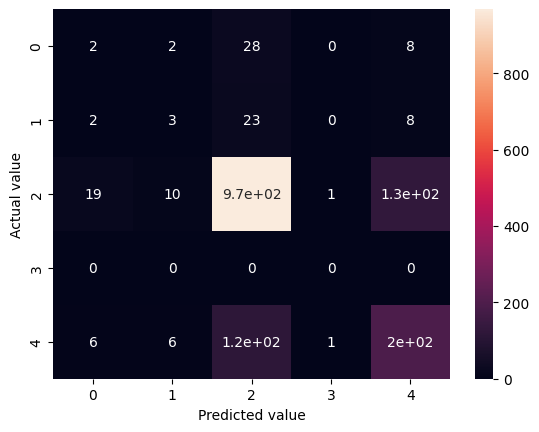

In [ ]:
fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(rf_conf_matrix), annot=True)
plt.ylabel('Actual value')
plt.xlabel('Predicted value')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Features and labels
features = classificationDF[['Count_Transactions', 'SumTotal', 'SumAvg', 'SumMax', 'SumMin']]
labels = classificationDF['type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)

# Get feature importance with feature names
feature_importance_dt = dict(zip(features.columns, dt_classifier.feature_importances_))

# Evaluation for Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)

# Extract precision and recall for Decision Tree
precision_dt, recall_dt, _, _ = precision_recall_fscore_support(y_test, y_pred_dt, average='weighted')

# Print the results for Decision Tree
print(f'Decision Tree Classifier Results:')
print(f'Accuracy: {accuracy_dt}')
print(f'Precision: {precision_dt}')
print(f'Recall: {recall_dt}')
print(f'Confusion Matrix:\n{conf_matrix_dt}')
print(f'Classifier Report:\n{class_report_dt}')
print(f'Feature Importance:')
for feature, importance in feature_importance_dt.items():
    print(f'{feature}: {importance}')

Decision Tree Classifier Results:
Accuracy: 0.7531106745252129
Precision: 0.751302482492493
Recall: 0.7531106745252129
Confusion Matrix:
[[  3   2  26   0   9]
 [  6   2  21   0   7]
 [ 19  16 951   1 139]
 [  0   0   0   0   0]
 [  7   6 117   1 194]]
Classifier Report:
              precision    recall  f1-score   support

   exchanges       0.09      0.07      0.08        40
    gambling       0.08      0.06      0.06        36
    historic       0.85      0.84      0.85      1126
      mining       0.00      0.00      0.00         0
     service       0.56      0.60      0.58       325

    accuracy                           0.75      1527
   macro avg       0.31      0.31      0.31      1527
weighted avg       0.75      0.75      0.75      1527

Feature Importance:
Count_Transactions: 0.048226859575233275
SumTotal: 0.17045517416772346
SumAvg: 0.2813179454389244
SumMax: 0.21640493871206645
SumMin: 0.28359508210605233


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

Text(0.5, 23.52222222222222, 'Predicted\xa0value')

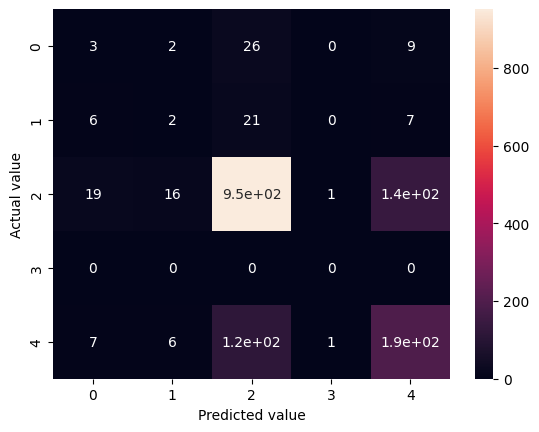

In [ ]:
fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(conf_matrix_dt), annot=True)
plt.ylabel('Actual value')
plt.xlabel('Predicted value')

#### Discussion

**Explain your code and discuss results**

The 7 pieces of code that we provided for this exercise explore the creation of classification models for assigning labels to addresses and use those labels assigned in the provided dataset, for training and testing datasets. We decided to build two models in order to compare results and the values of the metrics between them. The models that we built intend to predict the type of bitcoin transaction (“historic”, “service”, “gambling”,” exchanges” or “mining”) using relevant features such as total and average amount of transactions, count of transactions and maximum and minimum transactions.

Firstly, we are using "210000-224000.csv.gz" for transactions and “labels-210000-224000.csv.gz” for the labels of the transactions. To analyse the results, we decided to just keep solutions that use a random 20% of the entire dataset because if we used the entire dataset, it would take a lot of time to run it and would also spend a lot of computing resources.
We decided to perform a Decision Tree Classifier and a Random Forest Classifier over some other classification models that we learned in class such as kNN or SVM because decision trees and random forests can model non-linear relationships in the data. If the data has complex, non-linear patterns, decision trees and random forests may capture them more effectively than linear models like SVM. Also, random forests provide a feature importance ranking, which can help you identify the most influential features in the dataset. This can be useful for future feature selection and gaining insights into the factors driving predictions.

Additionally, random forests are an ensemble of decision trees. Ensemble methods, in general, tend to improve the model's performance by reducing overfitting and increasing generalization. Random forests, by aggregating the predictions of multiple trees, often perform well on a variety of datasets. Finally, decision trees and random forests can be computationally more efficient than kNN or SVM, especially as the size of the dataset increases which is the case here. Training a single decision tree is generally faster than training complex models like SVM on large datasets. Also, they have fewer hyperparameters to tune compared to kNN or SVM. Similarly, as the kNN or the SVM, the Random Forest Classifier and the Decision Tree Classifier can be find in the sci-kit library.

The first three pieces of code perform a preprocessing of the entire dataset by calculating the features into a featuresDF and assigning the labels to addresses. The result is a classificationDF that we’ll use in the models.

The fourth and the fifth snippet code use scikit-learn to train a Random Forest Classifier on a subset of the classificationDF, evaluates its performance on a test set, and prints the accuracy, precision, recall, confusion matrix, classification report, and feature importance and a heatmap using the Seaborn library to visualize the confusion matrix (rf_conf_matrix) of a Random Forest Classifier, annotating the cells with the corresponding values, and labelling the axes as "Actual value" and "Predicted value.

The results will always depend on the number of records per category that the code randomly assigns while sub setting the dataset. There might exist alternative solutions such as a balanced subset to get the same number of records for each type that we didn’t get to have time to explore (for example, creating a subset with 100 historic records, 100 service records, 100 gambling records, 100 exchange records and 100 mining records). The Random Forest Classifier achieved an accuracy of 76.5%, with precision and recall scores of approximately 75.6%. The confusion matrix indicates varying levels of correct and misclassified predictions across different classes, while the classification report provides detailed metrics for each class, and feature importance highlights the contribution of individual features to the model's decision-making.

We can conclude that the model performs well for the "historic" class, with high precision, recall, and F1-score. Also, the model struggles with classes like "exchanges" and "gambling," where both precision and recall are relatively low. The "mining" class has a precision of 0.00, indicating that the model did not predict any instances for this class. However, the recall is not defined since there are no true samples for this class in the test set. The "service" class shows a decent balance between precision and recall. The heatmap in the following piece of code shows these conclusions visually.

Finally, the sixth and seventh pieces of code execute the same approach of the fourth and fifth but with a Decision Tree Classifier. The Decision Tree Classifier achieved an accuracy of 75.3%, which is comparable to the Random Forest Classifier. Precision and recall are both around 75.1%, indicating a balanced performance between precision and recall. Similarly, to the Random Forest Classifier, the confusion matrix provides a breakdown of correct and incorrect predictions for each class. Some misclassifications are observed, with varying degrees across different classes.

The Decision Tree Classifier provides high performance like the Random Forest Classifier, with comparable accuracy, precision, and recall. Both models exhibit challenges in distinguishing classes like "exchanges" and "gambling," where precision and recall are relatively low. The "historic" class shows relatively high precision, recall, and F1-score. Similarly, to the Random Forest Classifier, the "mining" class has a precision of 0.00, indicating no positive predictions, and the recall is not defined due to zero true samples.
The heatmap in the following piece of code also shows these conclusions visually. For both models, we can also see the level of importance of each feature.

In summary, the Decision Tree Classifier shows consistent performance with the Random Forest Classifier as well as a good overall score in both. Since building the best classification model is a never-ending task, further analysis or potential model improvement should be always considered in some classes such as mining.


## Exercise 4 [4 points]

Consider we didn't have the labels for the address, but that you would want to create groups of addresses. Propose a solution.


In [ ]:
date_cols = ["date_first_tx"]
path = os.path.join(LABEL_DIR, LABELDATA_FILE)
labels_df = pd.read_csv(path, compression="gzip", parse_dates=date_cols)

In [ ]:
import os
import ast
import pandas as pd

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, LGDATA_FILE)
df = pd.read_csv(path, compression="gzip", parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputdf_labels = df[["TxId", "Height", "Input", "Sum", "Time"]].explode("Input")
outputdf_labels = df[["TxId", "Height", "Output", "Sum", "Time"]].explode("Output")
outputdf_labels[["Output", "Value"]] = outputdf_labels["Output"].to_list()

labels_df['address'] = labels_df['address'].str.replace("'", '')
addresses = labels_df['address'].to_list()
labels_input = inputdf_labels[inputdf_labels['Input'].isin(addresses)]
labels_output = outputdf_labels[outputdf_labels['Output'].isin(addresses)]

In [ ]:
in_address = labels_input[['Input', 'TxId']].groupby('Input').count().rename(columns={'TxId': 'Count_Input'})
out_address = labels_output[['Output', 'TxId']].groupby('Output').count().rename(columns={'TxId': 'Count_Output'})
address = in_address.join(out_address, how='outer').fillna(0)

address['Count_Transactions'] = address['Count_Input'] + address['Count_Output']

sum_max_address = labels_input[['Input', 'Sum']].groupby('Input').max().rename(columns={'Sum': 'SumMax'})
sum_min_address = labels_input[['Input', 'Sum']].groupby('Input').min().rename(columns={'Sum': 'SumMin'})

sum_in_address = labels_input[['Input', 'Sum']].groupby('Input').sum().rename(columns={'Sum': 'SumTotal'})
sum_avg_address = labels_input[['Input', 'Sum']].groupby('Input').mean().rename(columns={'Sum': 'SumAvg'})

featuresDF = address.join(sum_in_address, how='inner').fillna(0)
featuresDF = featuresDF.join(sum_avg_address, how='inner').fillna(0)
featuresDF = featuresDF.join(sum_max_address, how='inner').fillna(0)
featuresDF = featuresDF.join(sum_min_address, how='inner').fillna(0).reset_index().rename(columns={'index': 'Input'})

classificationDF = pd.merge(featuresDF, labels_df, right_on='address', left_on='Input')

<ipython-input-20-21e5c468929f>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_stats = featuresDF.groupby('Cluster').mean()


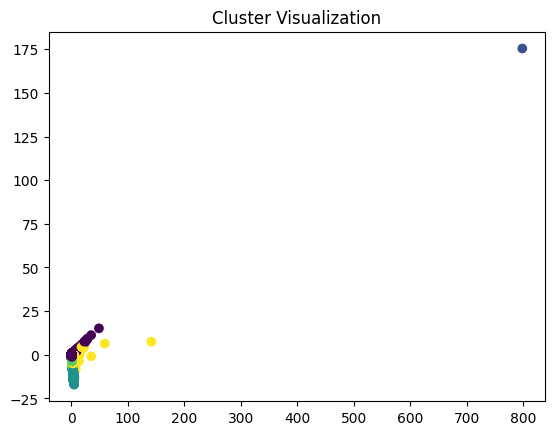

In [ ]:
import os
import ast
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(featuresDF.iloc[:, 1:])

# Clustering (K-Means)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
featuresDF['Cluster'] = kmeans.fit_predict(scaled_features)

# Explore the Clusters
cluster_stats = featuresDF.groupby('Cluster').mean()

# Visualization using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=featuresDF['Cluster'], cmap='viridis')
plt.title('Cluster Visualization')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# Assuming featuresDF contains the clustering information
# You may need to adjust this depending on how your clustering results are stored
classificationDF['Cluster'] = featuresDF['Cluster']

# Subsetting the data
classificationDF = classificationDF.sample(frac=0.2)

# Features and labels
features = classificationDF[['Cluster']]
label = classificationDF['type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_y_pred = rf_classifier.predict(X_test)

# Get feature importance with feature names
feature_importance_rf = dict(zip(features.columns, rf_classifier.feature_importances_))

# Evaluation
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
rf_class_report = classification_report(y_test, rf_y_pred)

# Extract precision and recall
rf_precision, rf_recall, _, _ = precision_recall_fscore_support(y_test, rf_y_pred, average='weighted')

# Print the results
print(f'Random Forest Classifier Results:')
print(f'Accuracy: {rf_accuracy}')
print(f'Precision: {rf_precision}')
print(f'Recall: {rf_recall}')
print(f'Confusion Matrix:\n{rf_conf_matrix}')
print(f'Classifier Report:\n{rf_class_report}')
print(f'Feature Importance:')
for feature, importance in feature_importance_rf.items():
    print(f'{feature}: {importance}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Classifier Results:
Accuracy: 0.7338572364112639
Precision: 0.5385464434331777
Recall: 0.7338572364112639
Confusion Matrix:
[[   0    0  207    0    0]
 [   0    0  141    0    0]
 [   0    0 5603    0    0]
 [   0    0    4    0    0]
 [   0    0 1680    0    0]]
Classifier Report:
              precision    recall  f1-score   support

   exchanges       0.00      0.00      0.00       207
    gambling       0.00      0.00      0.00       141
    historic       0.73      1.00      0.85      5603
      mining       0.00      0.00      0.00         4
     service       0.00      0.00      0.00      1680

    accuracy                           0.73      7635
   macro avg       0.15      0.20      0.17      7635
weighted avg       0.54      0.73      0.62      7635

Feature Importance:
Cluster: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 23.52222222222222, 'Predicted\xa0value')

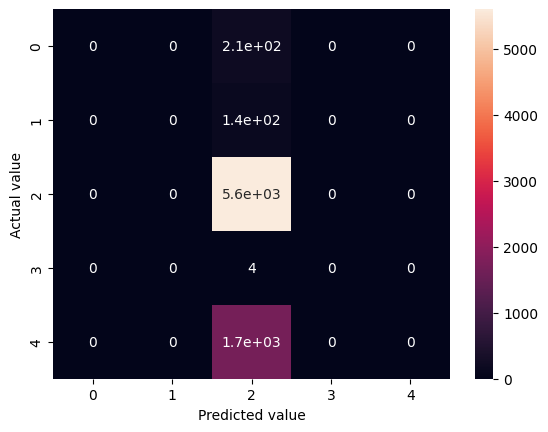

In [ ]:
fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(rf_conf_matrix), annot=True)
plt.ylabel('Actual value')
plt.xlabel('Predicted value')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Assuming featuresDF contains the clustering information
# You may need to adjust this depending on how your clustering results are stored
classificationDF['Cluster'] = featuresDF['Cluster']

# Features and labels
features = classificationDF[['Cluster']]
label = classificationDF['type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_y_pred = dt_classifier.predict(X_test)

# Get feature importance with feature names
feature_importance_dt = dict(zip(features.columns, dt_classifier.feature_importances_))

# Evaluation
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)
dt_class_report = classification_report(y_test, dt_y_pred)

# Extract precision and recall for Decision Tree
dt_precision, dt_recall, _, _ = precision_recall_fscore_support(y_test, dt_y_pred, average='weighted')

# Print the results for Decision Tree Classifier
print(f'Decision Tree Classifier Results:')
print(f'Accuracy: {dt_accuracy}')
print(f'Precision: {dt_precision}')
print(f'Recall: {dt_recall}')
print(f'Confusion Matrix:\n{dt_conf_matrix}')
print(f'Classifier Report:\n{dt_class_report}')
print(f'Feature Importance:')
for feature, importance in feature_importance_dt.items():
    print(f'{feature}: {importance}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree Classifier Results:
Accuracy: 0.7338572364112639
Precision: 0.5385464434331777
Recall: 0.7338572364112639
Confusion Matrix:
[[   0    0  207    0    0]
 [   0    0  141    0    0]
 [   0    0 5603    0    0]
 [   0    0    4    0    0]
 [   0    0 1680    0    0]]
Classifier Report:
              precision    recall  f1-score   support

   exchanges       0.00      0.00      0.00       207
    gambling       0.00      0.00      0.00       141
    historic       0.73      1.00      0.85      5603
      mining       0.00      0.00      0.00         4
     service       0.00      0.00      0.00      1680

    accuracy                           0.73      7635
   macro avg       0.15      0.20      0.17      7635
weighted avg       0.54      0.73      0.62      7635

Feature Importance:
Cluster: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 23.52222222222222, 'Predicted\xa0value')

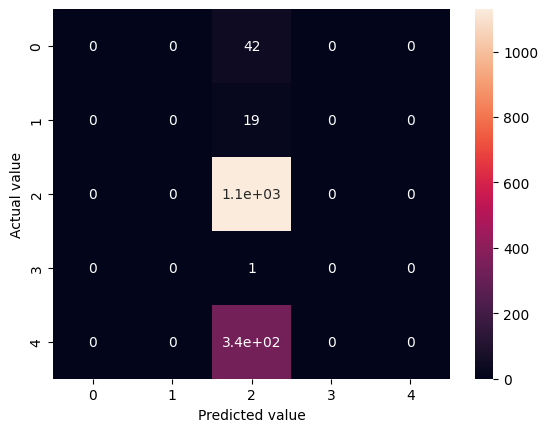

In [ ]:
fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(dt_conf_matrix), annot=True)
plt.ylabel('Actual value')
plt.xlabel('Predicted value')

#### Discussion

**Explain your code and discuss results**

The exercise 4 follows the same logic as 3 but there is one condition in the question that changes the approach: we didn't have the labels for the address and we want to create groups of addresses. The solution could to be found by developing a model similarly as stated in question 3.

As in 3, the code starts by processing the dataset related to transactions and addresses and creating features from the data. The fourth piece of the code is the most important because it utilizes unsupervised learning techniques, specifically K-Means clustering and Principal Component Analysis (PCA), to identify patterns and groupings within a dataset.

It scales the features using StandardScaler, applies K-Means clustering with five clusters, explores cluster characteristics through statistical analysis, and visually represents the clusters in a 2D space using PCA, providing insights into the inherent structure of the data without relying on predefined labels. The cluster visualization obtained from the plot, with a multitude of clusters concentrated in the bottom left and a lone cluster in the top-right, indicates a dominant pattern among most addresses, while the isolated cluster may represent outliers or addresses with unique transaction characteristics.
We thought of using t-SNE for cluster visualization instead of PCA because it may be advantageous in capturing non-linear patterns, preserving local structures, handling crowded clusters, and providing a more informative representation, especially when dealing with high-dimensional data which is the case here. We ended choosing PCA because it’s faster and spend less time running.

The result of the Random Forest Classifier achieved an accuracy of 73.4%, with precision and recall both around 53.9%. The precision and recall values indicate that the model's performance is not balanced across classes which is normal because can't see the labels for the addresses. The confusion matrix shows that the model is predicting most instances as the "historic" class (label 2), leading to a lack of diversity in predictions. There are no predictions for the "exchanges," "gambling," and "mining" classes. Precision, recall, and F1-score metrics indicate poor performance for the "exchanges," "gambling," "mining," and "service" classes. The high recall for the "historic" class is due to the imbalanced nature of the dataset, where most instances belong to this class. Also, the feature importance analysis highlights that the decision tree heavily relies on the "Cluster" feature for decision-making.

Finally, the model shows a lack of sensitivity to minority classes ("exchanges," "gambling," "mining," and "service"), as indicated by low precision, recall, and F1-score values for these classes. It tends to predict most instances as the majority class ("historic"), leading to high recall for this class but poor performance for others. The overall accuracy might be misleading due to the dominance of the "historic" class in the dataset. The plot also evidences the statements made above. The following plot confirms these results

On the other hand, the Decision Tree Classifier achieved an accuracy of 73.4%, with precision and recall both around 53.9%, identical to the Random Forest Classifier.
Like the Random Forest Classifier, the precision and recall values indicate an imbalanced performance across classes. The confusion matrix is identical to that of the Random Forest Classifier, indicating that the Decision Tree Classifier also tends to predict most instances as the "historic" class. Precision, recall, and F1-score metrics are consistent with the overall imbalanced performance across classes.

Concluding, the Decision Tree Classifier demonstrates similar imbalanced class predictions as the Random Forest Classifier, with a focus on the majority class ("historic"). The overall accuracy might be misleading due to the dominance of the "historic" class in the dataset. The following plot also confirms these results

For both models, further analysis, data preprocessing (such as addressing class imbalance), or model tuning may be necessary to improve performance on minority classes. The results are poor because we are using unsupervised learning techniques, so it’s difficult to find a better result when compared to supervised learning techniques.

Also, it is important to state that the results will always depend on the number of records per category that the code randomly assigns while sub setting the dataset. That can explain the higher number of predictions in the historic category. There might exist alternative solutions such as a balanced subset to get the same number of records for each type that we didn’t get to have time to explore (for example, creating a subset with 100 historic records, 100 service records, 100 gambling records, 100 exchange records and 100 mining records).


## Exercise 5 [3+1 points]

Propose a problem to solve and implement it (for 3 points).

Use cuDF/cuML/cuGrpahs for 1 extra point.

In [ ]:
import pandas as pd

# Assuming classificationDF is your DataFrame
classificationDF['date_first_tx'] = pd.to_datetime(classificationDF['date_first_tx']).dt.strftime('%m/%d/%Y')
classificationDF['date_first_tx'] = classificationDF['date_first_tx'].astype(str)

# Rename the column to "Date"
classificationDF = classificationDF.rename(columns={'date_first_tx': 'Date'})


In [ ]:
!nvidia-smi

Sat Dec  2 21:11:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 400 (delta 95), reused 52 (delta 51), pack-reused 269
Receiving objects: 100% (400/400), 109.76 KiB | 15.68 MiB/s, done.
Resolving deltas: 100% (197/197), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 906.5 kB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Found existing installation: cupy-cuda11x 11.0.0
Uninstalling cupy-cuda11x-11.0.0:
  Successfully uninstalled cupy-cuda11x-11.0.0
PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntu-toolchain-r/test/ubuntu/ jammy main'
Description:
Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntu-toolchain-r-ubuntu-test.gpg with fingerprint 60C317803A41BA51845E371A1E9377A2BA9EF27F
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/rep

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.15.1
Uninstalling cffi-1.15.1:
  Successfully uninstalled cffi-1.15.1
Found existing installation: cryptography 40.0.1
Uninstalling cryptography-40.0.1:
  Successfully uninstalled cryptography-40.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.3/446.3 kB 17.6 MB/s eta 0:00:00
Installing RAPIDS Stable 23.10
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mamba


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca

In [ ]:
import cudf, cuml, cugraph, cuspatial

In [ ]:
cudf.__version__

'23.10.02'

/usr/local/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Mean Squared Error: 42.773579778598524


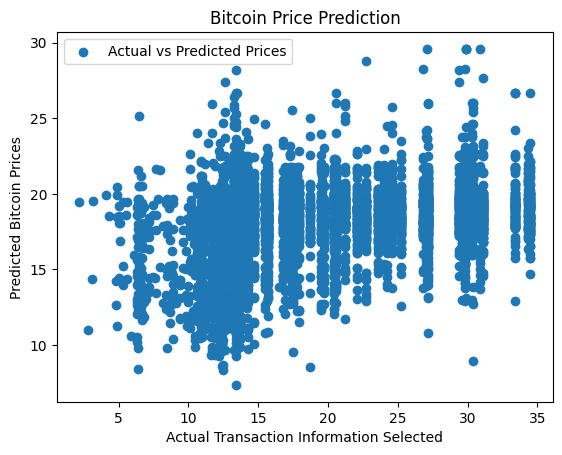

In [ ]:
# Import necessary libraries
import os
import cudf
import cuml
import cugraph
from cuml.model_selection import train_test_split
from cuml.metrics import mean_squared_error
import matplotlib.pyplot as plt

date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)
bitcoin_prices = pd.read_csv(path, parse_dates=date_cols)

# Assuming 'Date' column needs to be converted to datetime in classificationDF
classificationDF['Date'] = pd.to_datetime(classificationDF['Date'])

# Merge datasets based on timestamp or date
merged_df = cudf.merge(classificationDF, bitcoin_prices, on='Date', how='inner')

# Feature selection
X = merged_df[['Count_Transactions', 'SumTotal', 'SumAvg', 'SumMax', 'SumMin']]
y = merged_df['Price']

# Assuming X and y are pandas DataFrame and Series respectively
X_cudf = cudf.from_pandas(X)
y_cudf = cudf.from_pandas(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)

# Train a machine learning model (Random Forest) using cuML
model = cuml.ensemble.RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Visualize the predicted prices against the actual prices
plt.scatter(y_test.to_pandas().to_numpy(), y_pred.to_pandas().to_numpy(), label='Actual vs Predicted Prices')
plt.xlabel('Actual Transaction Information Selected')
plt.ylabel('Predicted Bitcoin Prices')
plt.title('Bitcoin Price Prediction')

# Add legend
plt.legend()

plt.show()

#### Discussion

**Explain your code and discuss results**

Considering the subject of this assignment, we were challenged to propose a problem to solve and implement it using cuDF/cuML/cuGraphs. Our suggestion relies on the fact that we have a dataset called classificationDF containing various numerical features related to transactions and partners, and another dataset with Bitcoin prices and the date of the price. Our goal is to predict Bitcoin prices based on the information available in the features from the classificationDF.
To achieve that, we performed a regression model where we only selected numerical values because we are trying to predict a numerical value. Before developing the model, the first piece of code makes sure that the date column of the bitcoins price data frame is in the same format as the date in the classificationDF. Then, we used the features that we calculated in exercise 3 to predict the price and then we define the price as target variable.

The most important code part, is the second which explicitly does the following tasks:
•	Imports necessary libraries for data manipulation, machine learning, and visualization.

•	Reads Bitcoin price data from a CSV file into a Pandas DataFrame.

•	Converts the 'Date' column in a Data Frame named 'classificationDF' to datetime format.

•	Merges two Data Frames, 'classificationDF' and 'bitcoin_prices,' based on the 'Date' column using cuDF (GPU-accelerated DataFrame library).

•	Selects specific features ('Count_Transactions', 'SumTotal', 'SumAvg', 'SumMax', 'SumMin') and the target variable ('Price') from the merged DataFrame.

•	Converts the selected features and target variable to cuDF format.

•	Splits the dataset into training and testing sets using cuML's train_test_split function.

•	Trains a Random Forest regression model on the training set using cuML.

•	Makes predictions on the test set using the trained model.

•	Evaluates the model performance by calculating the mean squared error between the predicted and actual values.

•	Visualizes the predicted Bitcoin prices using a scatter plot.

Given that the prices are expressed in tenths, an Mean Squared Error (MSE) value of 42.77 implies that, on average, the model's predictions deviate by approximately 42.77 tenths from the actual values in the test set, suggesting a moderate level of prediction error that may warrant further refinement of the model.

Lastly, the scatter plot reinforces this tendency by showing a positive slope with closely clustered points around the regression line, suggesting that the model captures the general trend in the data, but there is a moderate level of deviation from the actual values, indicating the potential for further refinement to improve precision. Techniques that might improve the model include hyperparameter-tuning or a new selection of more relevant features.
